# Reinforcement Learning:Assignment 3
In this assignment we will learn how to implement the On-policy Sarsa and off-policy Q-learning algorithms.

## Grid World Environement

The environement is a grid where the agent can go from one case to the next.

**Description**:
- **States:** the different position on the grid. `S` indicates the start state and `G` indicates the final state.
- **Actions:** up (`0`), right (`1`), down (`2`), and left (`3`).
- **Rewards:** `-5` for bumping into a wall, `+10` for reaching the goal, and `0` otherwise.
- **Discount factor:** $\gamma = 0.9$

We will use the environement called: `Grid`

In [2]:
from enum import Enum
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-notebook')
plt.style.use('seaborn-whitegrid')

class Action(Enum):
    UP = 0
    RIGHT = 1
    DOWN = 2
    LEFT = 3

class Grid():
  def __init__(self, discount=0.9, penalty_for_walls=-5):
    # -1: wall
    # 0: empty, episode continues
    # other: number indicates reward, episode will terminate
    self._layout = np.array([
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
      [-1,  0,  0,  0,  0,  0, -1,  0,  0, -1],
      [-1,  0,  0,  0, -1,  0,  0,  0, 10, -1],
      [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
      [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
    ])
    self._start_state = (2, 2)
    self._goal_state = (8, 2)
    self._state = self._start_state
    self._number_of_states = np.prod(np.shape(self._layout))
    self._discount = discount
    self._penalty_for_walls = penalty_for_walls
    self._layout_dims = self._layout.shape
    self._name = 'Grid'

  @property
  def number_of_states(self):
      return self._number_of_states

  def plot_grid(self):
    plt.figure(figsize=(3, 3))
    plt.imshow(self._layout <= -1, interpolation="nearest")
    ax = plt.gca()
    ax.grid(0)
    plt.xticks([])
    plt.yticks([])
    plt.title(self._name)
    plt.text(
        self._start_state[0], self._start_state[1],
        r"$\mathbf{S}$", ha='center', va='center')
    plt.text(
        self._goal_state[0], self._goal_state[1],
        r"$\mathbf{G}$", ha='center', va='center')
    h, w = self._layout.shape
    for y in range(h-1):
      plt.plot([-0.5, w-0.5], [y+0.5, y+0.5], '-k', lw=2)
    for x in range(w-1):
      plt.plot([x+0.5, x+0.5], [-0.5, h-0.5], '-k', lw=2)


  def get_obs(self):
    y, x = self._state
    return y*self._layout.shape[1] + x

  def int_to_state(self, int_obs):
    x = int_obs % self._layout.shape[1]
    y = int_obs // self._layout.shape[1]
    return y, x

  def step(self, action: Action):
    y, x = self._state

    if action == Action.UP:  # up
      new_state = (y - 1, x)
    elif action == Action.RIGHT:  # right
      new_state = (y, x + 1)
    elif action == Action.DOWN:  # down
      new_state = (y + 1, x)
    elif action == Action.LEFT:  # left
      new_state = (y, x - 1)
    else:
      raise ValueError("Invalid action: {}".format(action))

    new_y, new_x = new_state
    if self._layout[new_y, new_x] == -1:  # wall
      reward = self._penalty_for_walls
      discount = self._discount
      new_state = (y, x)
    elif self._layout[new_y, new_x] == 0:  # empty cell
      reward = 0.
      discount = self._discount
    else:  # a goal
      reward = self._layout[new_y, new_x]
      discount = 0.
      new_state = self._start_state

    self._state = new_state
    return reward, discount, self.get_obs()

<ipython-input-2-fd0353e6ae65>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-notebook')
<ipython-input-2-fd0353e6ae65>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


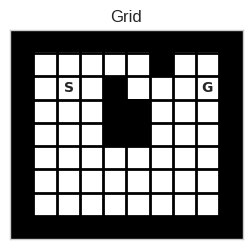

In [3]:
grid = Grid()
grid.plot_grid()

In [4]:
grid._start_state

(2, 2)

In [5]:
# Simple interaction loop with the MDP:
# 1) Interact with the environment
# 2) Agent gets observation, rewards, and discount from env.
# and is expected to produce the next action
def run_experiment(env, agent, number_of_steps, epsilon):
    mean_reward = 0.
    action = agent.initialAction()
    # Interaction wih the MDP
    for i in range(number_of_steps):

      reward, discount, next_state = env.step(action)
      action = agent.step(reward, discount, next_state, epsilon)

      mean_reward += (reward - mean_reward)/(i + 1.)

    return mean_reward

In [6]:
# Functions to use for Visualization
map_from_action_to_subplot = lambda a: (2, 6, 8, 4)[a.value]

def plot_values(values, colormap='pink', vmin=-1, vmax=10):
  plt.imshow(values, interpolation="nearest", cmap=colormap, vmin=vmin, vmax=vmax)
  plt.yticks([])
  plt.xticks([])
  plt.colorbar(ticks=[vmin, vmax])

# Visualising the e-greedy value function V^{\mu}
def plot_state_value(action_values, epsilon=0.1):
  q = action_values
  fig = plt.figure(figsize=(4, 4))
  vmin = np.min(action_values)
  vmax = np.max(action_values)
  v = (1 - epsilon) * np.max(q, axis=-1) + epsilon * np.mean(q, axis=-1)
  plot_values(v, colormap='summer', vmin=vmin, vmax=vmax)
  plt.title("$d(s)$")

# Visualising all value functions, for all actions
def plot_action_values(action_values, epsilon=0.1):
  q = action_values
  fig = plt.figure(figsize=(8, 8))
  fig.subplots_adjust(wspace=0.3, hspace=0.3)
  vmin = np.min(action_values)
  vmax = np.max(action_values)
  dif = vmax - vmin
  for a in list(Action):
    plt.subplot(3, 3, map_from_action_to_subplot(a))

    plot_values(q[..., a.value], vmin=vmin - 0.05*dif, vmax=vmax + 0.05*dif)
    action_name = a.name
    plt.title(r"$q(s, \mathrm{" + action_name + r"})$")

  plt.subplot(3, 3, 5)
  v = (1 - epsilon) * np.max(q, axis=-1) + epsilon * np.mean(q, axis=-1)
  plot_values(v, colormap='summer', vmin=vmin, vmax=vmax)
  plt.title("$v(s)$")


def smooth(x, window=10):
  return x[:window*(len(x)//window)].reshape(len(x)//window, window).mean(axis=1)

def plot_stats(stats, window=10):
  plt.figure(figsize=(16,4))
  plt.subplot(121)
  xline = range(0, len(stats.episode_lengths), window)
  plt.plot(xline, smooth(stats.episode_lengths, window=window))
  plt.ylabel('Episode Length')
  plt.xlabel('Episode Count')
  plt.subplot(122)
  plt.plot(xline, smooth(stats.episode_rewards, window=window))
  plt.ylabel('Episode Return')
  plt.xlabel('Episode Count')

def plot_policy(grid, policy):
  action_names = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"]
  grid.plot_grid()
  plt.title('Policy Visualization')
  for i in range(9):
    for j in range(10):
      if grid._layout[i][j] != -1 and (grid._layout[i][j] != 10):
        action_name = action_names[policy[i,j]]
        plt.text(j, i, action_name, ha='center', va='center')

def visualise_policy(grid, agent):
  pi = np.zeros(grid._layout_dims, dtype=np.int32)
  for i in range(grid._layout_dims[0]):
    for j in range(grid._layout_dims[1]):
      state = i*grid._layout.shape[1] + j
      pi[i, j] = agent.greedy_policy_step(state, epsilon=0.).value
  plot_policy(grid, pi)

### Exercise I: Implementing the Sarsa algorithm

**Description of Sarsa Algorithm (On-policy control for estimating $Q \approx q^*$):**

**Algorithm parameters**: step size $\alpha \in (0, 1]$, small $\epsilon > 0$

- Initialize $Q(s,a)$ arbitrarily except that $Q(terminal,\cdot\;) = 0$

- Loop for each episode:

    - Initialize $S$

    - Choose $A$ from $S$ using policy derived from $Q$ (e.g., $\epsilon$-greedy)
  
    - Loop for each step of episode:

        1. Take action $A$, observe $R$, $S^\prime$
        2. Choose $A^\prime$ from $S^\prime$ using policy derived from $Q$ (e.g., $\epsilon$-greedy)
        3. $Q(S, A)  = Q(S, A) + \alpha * (R + \gamma Q(S^\prime, A^\prime) - Q(S, A))$
        4. $S = S^\prime$, $A = A^\prime$ until S is terminal

In [7]:
from collections import defaultdict

class SarsaAgent():
  def __init__(
      self, number_of_states, actions, initial_state,
      step_size=0.1):
    self._state = initial_state
    self._number_of_states = number_of_states
    self._step_size = step_size
    self._actions = actions
    self._action = self.initialAction()
    # initialize your q-values (this is a table indexed by state and action pairs)
    # self._q = defaultdict(lambda: np.zeros(len(actions))) # ToDo: Write your code here
    self._q = np.zeros((number_of_states, 4))
    self.initial_state = initial_state

  def reset(self):
    self._state = self.initial_state
    self._action = self.initialAction()
    self._q = np.zeros((self._number_of_states, 4))

  @property
  def q_values(self):
    return self._q

  def initialAction(self):
    return self._actions(0)


  def greedy_policy_step(self, state, epsilon):
    # make epsilon-greedy policy step and return an action
    # Write you code here
    #ToDo

    # probability of acting greedy is 1 - epsilon * epsilon / n
    # probability of chosing and arbitrary action (exploration) is epsilon / n

    state_proba = (epsilon / len(self._actions)) * np.ones(len(self._actions))
    best_state_action = np.argmax(self._q[state])
    state_proba[best_state_action] = (1 - epsilon) + (epsilon / len(self._actions))

    # choose an action according to the epsilon greedy policy
    action = np.random.choice(self._actions, p=state_proba)

    return action

  def step(self, reward, discount, next_state, epsilon):
    s = self._state
    a = self._action

    # get the index of the action
    a_idx = a.value
    alpha = self._step_size
    self._state = next_state
    #ToDo

    # next action according to e-greedy policy
    a_next = self.greedy_policy_step(next_state, epsilon)
    a_next_idx = a_next.value
    s_next = next_state

    # updating the q table according to the next state and the epsilon greedy action in the next state
    self._q[s, a_idx] += (alpha * (reward + (discount * self._q[s_next, a_next_idx]) - self._q[s, a_idx]))

    self._action = a_next
    return self._action

### Testing your solution

Streaming output truncated to the last 5000 lines.
0.521989010757663
0.5219835163100061
0.5219780219780168
0.5219725277616916
0.5219670336610267
0.5219615396760187
0.5219560458066637
0.5219505520529581
0.5219450584148985
0.521939564892481
0.5219340714857019
0.5219285781945577
0.5219230850190447
0.5219175919591592
0.5220173444472459
0.5220118505109561
0.5220063566903063
0.5220008629852926
0.5219953693959115
0.5219898759221594
0.5219843825640327
0.5219788893215276
0.5219733961946404
0.5219679031833677
0.5219624102877056
0.5219569175076506
0.521951424843199
0.5219459322943472
0.5219404398610914
0.5219349475434281
0.522034683054124
0.5220291898603592
0.5220236967821992
0.5220182038196403
0.5220127109726789
0.5220072182413114
0.522001725625534
0.5219962331253434
0.5219907407407356
0.521985248471707
0.5219797563182541
0.5219742642803732
0.5219687723580606
0.5219632805513127
0.5219577888601258
0.5218996917314541
0.5218942008248414
0.521888710033767
0.5218832193582275
0.521982935476739
0.52197

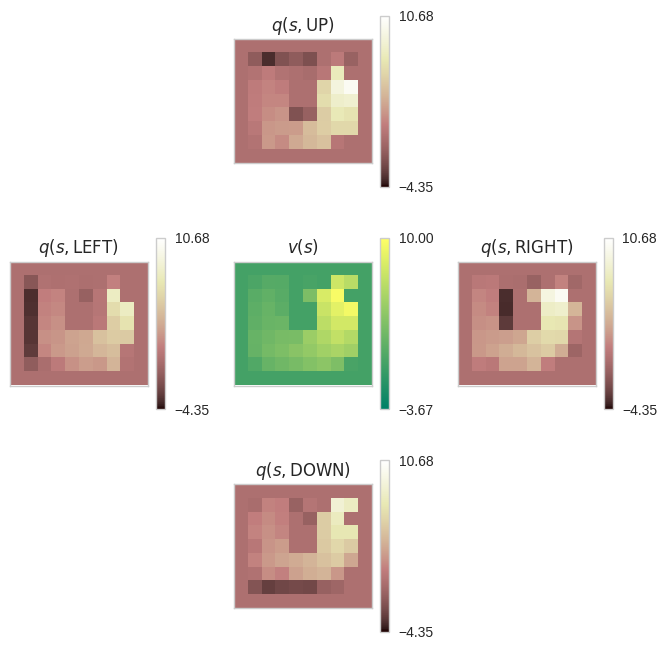

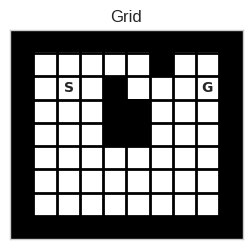

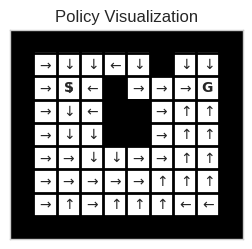

In [8]:
num_steps = 100000
epsilon=0.2

# environment
grid = Grid()

# agent
agent = SarsaAgent(
    number_of_states=grid._layout.size,
    actions=Action,
    initial_state=grid.get_obs(),
    step_size=0.1)

# run experiment and get the value functions from agent
mean_reward = run_experiment(grid, agent, num_steps, epsilon)

# get the q-values
q = agent.q_values.reshape(grid._layout.shape + (4,))

# visualize value functions
print('AFTER {} STEPS ...'.format(num_steps))
plot_action_values(q, epsilon=epsilon)
grid.plot_grid()
visualise_policy(grid, agent)

In [ ]:
mean_reward

0.4901999999999994

### Exercise II: Implementing the Q-learning algorithm

**Description of Q-learning Algorithm (Off-policy control for estimating $Q \approx q^*$):**

**Algorithm parameters**: step size $\alpha \in (0, 1]$, small $\epsilon > 0$

- Initialize $Q(s,a)$ arbitrarily except that $Q(terminal,\cdot\;) = 0$

- Loop for each episode:

    - Initialize $S$
  
    - Loop for each step of episode:

        1. Choose $A$ from $S$ using policy derived from $Q$ (e.g., $\epsilon$-greedy)
        2. Take action $A$, observe $R$, $S^\prime$.
        3. $Q(S, A)  = Q(S, A) + \alpha * (R + \gamma \underset{a}{\rm max}Q(S^\prime, A^\prime) - Q(S, A))$
        4. $S = S^\prime$, $A = A^\prime$ until S is terminal

In [ ]:
class QLearningAgent(object):

  def __init__(
      self, number_of_states, actions, initial_state,
      step_size=0.1):
    self.initial_state = initial_state
    self._state = initial_state
    self._number_of_states = number_of_states
    self._step_size = step_size
    self._actions = actions
    self._action = self.initialAction()

    # initialize your q-values (this is a table indexed by state and action pairs)
    self._q = np.zeros((number_of_states, 4)) # ToDo: Write your code here


  def reset(self):
    self._state = self.initial_state
    self._action = self.initialAction()
    self._q = np.zeros((self._number_of_states, 4))

  @property
  def q_values(self):
    return self._q

  def initialAction(self):
    return self._actions(0)


  def greedy_policy_step(self, state, epsilon):
    # make epsilon-greedy policy step and return an action
    # Write you code here
    #ToDo

    # probability of acting greedy is 1 - epsilon * epsilon / n
    # probability of chosing and arbitrary action (exploration) is epsilon / n
    state_proba = (epsilon / 4) * np.ones(4)
    best_state_action = np.argmax(self._q[state])
    state_proba[best_state_action] = (1 - epsilon) + (epsilon / 4)

    action = np.random.choice(list(self._actions), p=state_proba)

    return action

  def step(self, reward, discount, next_state, epsilon):
    s = self._state
    a = self._action
    self._state = next_state
    #ToDo
    a_idx = a.value
    alpha = self._step_size
    # updating the q table according to the greedy policy, it is an off policy algorithm, updates the table according to the greedy policy
    # and takes the next action according to the epsilon greedy policy
    action_q = np.argmax(self._q[next_state])
    self._q[s, a_idx] += (alpha * (reward + (discount * self._q[next_state, action_q]) - self._q[s, a_idx]))

    # take the next action according to the epsilon gredy policy
    self._action = self.greedy_policy_step(next_state, epsilon)

    return self._action

### Testing your solution

AFTER 100000 STEPS ...


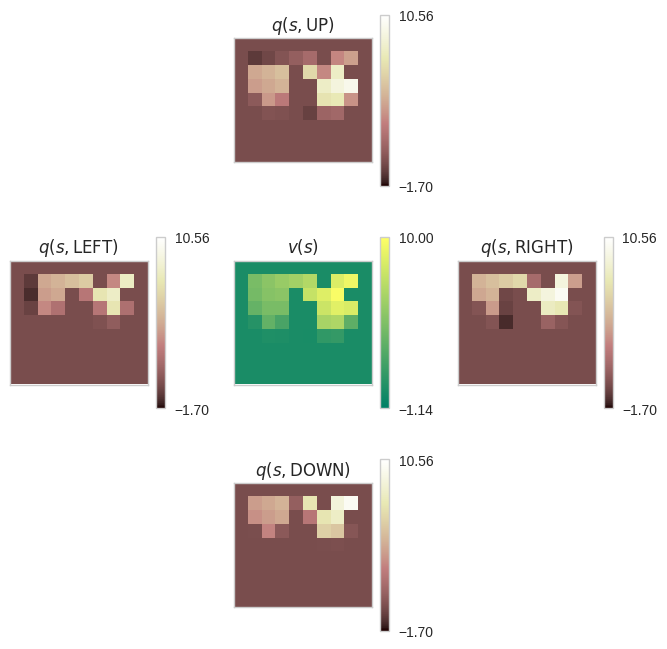

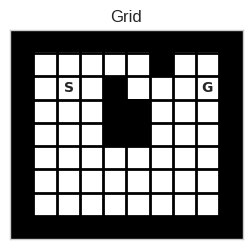

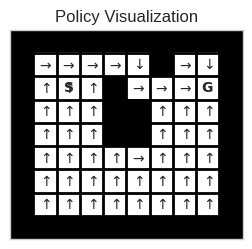

In [ ]:
num_steps = 100000
epsilon=0.2

# environment
grid = Grid()

# agent
agent = QLearningAgent(
    number_of_states=grid._layout.size,
    actions=Action,
    initial_state=grid.get_obs(),
    step_size=0.1)

# run experiment and get the value functions from agent
run_experiment(grid, agent, num_steps, epsilon)

# get the q-values
q = agent.q_values.reshape(grid._layout.shape + (4,))

# visualize value functions
print('AFTER {} STEPS ...'.format(num_steps))
plot_action_values(q, epsilon=epsilon)
grid.plot_grid()
visualise_policy(grid, agent)

### Tasks for both algorithms:
1. Plot the average reward as a function of the number of steps
2. Generate the above plot for different value of epsilon.
3. How different values of epsilon effect the training in both algorithms?
4. What is the optimal value for epsilon ?

## Questions are answered in the report

Q4- the best value for epsilon as below in the experiments was 0.1 for both algorithms.

In [ ]:
from tqdm.notebook import tqdm
import pandas as pd
def compare_rward(num_steps_lst, grid, agent, agent_name, epsilon):

  avg_reward_lst = []

  for i in tqdm(range(len(num_steps_lst))):
    steps = num_steps_lst[i]

    grid = Grid()
    avg_reward = run_experiment(grid, agent, steps, epsilon)
    avg_reward_lst.append(avg_reward)
    agent.reset()

  reward_df = pd.DataFrame({"num_steps": num_steps_lst, f"avg_reward_{agent_name}": avg_reward_lst})
  return reward_df

def plot_reward_steps(reward_df, epsilon):
  reward_df.plot(x = "num_steps", kind = "line", marker = "o")
  plt.title(epsilon)
  plt.show()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

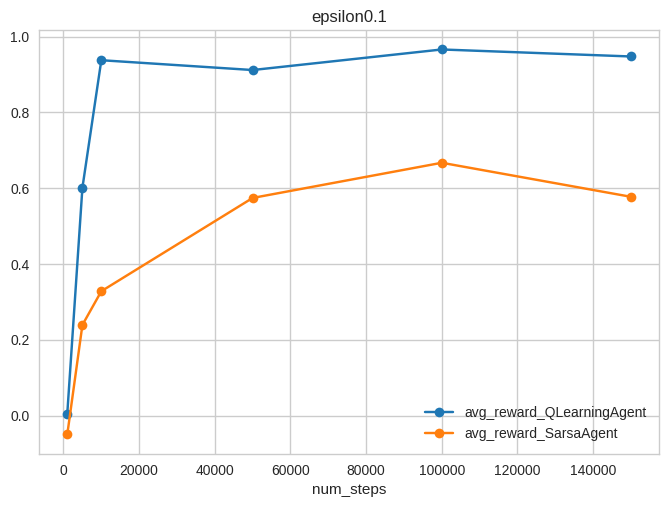

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

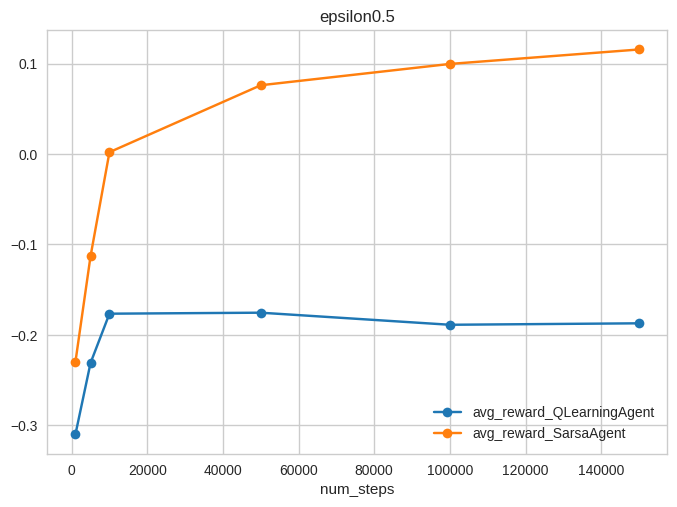

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

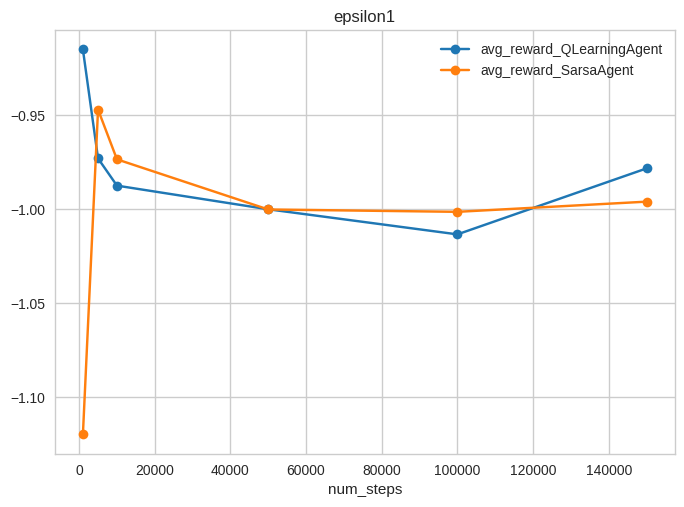

In [ ]:
for epsilon in [0.1, 0.5, 1]:

  num_steps_lst = [1000, 5000, 10000, 50000, 100000, 150000]

  agent_q_l = QLearningAgent(
      number_of_states=grid._layout.size,
      actions=Action,
      initial_state=grid.get_obs(),
      step_size=0.1)

  agent_sarsa = SarsaAgent(
      number_of_states=grid._layout.size,
      actions=Action,
      initial_state=grid.get_obs(),
      step_size=0.1)

  reward_df_q = compare_rward(num_steps_lst, grid, agent_q_l, "QLearningAgent", epsilon)
  reward_df_sarsa = compare_rward(num_steps_lst, grid, agent_sarsa, "SarsaAgent", epsilon)

  df_final = pd.merge(reward_df_q, reward_df_sarsa, on = "num_steps", how = "right")
  plot_reward_steps(df_final, "epsilon" + str(epsilon))